In [12]:
import sys
sys.path.append('../Utils')
import Solve_Slice
from Solve_Slice import find_B, scatter_pies, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music
from CreateRef import createscRef_py
import anndata as ad
import numpy as np
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# import numpy as np
# import rpy2.robjects as ro
# from scipy.sparse import csc_matrix

# ro.r['load']('../Data/sc_count.RData')

# i = np.array(ro.r('sc_count@i'), dtype=np.int32)    # row indices (0-based)
# p = np.array(ro.r('sc_count@p'), dtype=np.int32)    # col indptr
# x = np.array(ro.r('sc_count@x'), dtype=float)       # data
# nrow, ncol = map(int, list(ro.r('dim(sc_count)')))

# # Build CSC (matches R's dgCMatrix layout), then convert to CSR if you prefer
# X = csc_matrix((x, i, p), shape=(nrow, ncol)).tocsr()

# genes = [str(s) for s in list(ro.r('rownames(sc_count)'))]
# cells = [str(s) for s in list(ro.r('colnames(sc_count)'))]
# print(X.shape, len(genes), len(cells))


# # ---------- Load metadata (2nd RData) ----------
# import anndata as ad
# import pandas as pd
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import pandas2ri

# # X, genes, cells built above

# # Load metadata RData
# ro.r['load']('../Data/sc_meta.RData')

# # Try to find a cell metadata frame (rownames matching cells)
# cell_meta = None
# for nm in list(ro.r('ls()')):
#     if 'data.frame' in list(ro.r(f'class({nm})')):
#         rn = [str(s) for s in list(ro.r(f'rownames({nm})'))]
#         if set(cells).issubset(set(rn)):
#             with localconverter(ro.default_converter + pandas2ri.converter):
#                 cell_meta = ro.conversion.rpy2py(ro.r[nm]).loc[cells]
#             break
# if cell_meta is None:
#     cell_meta = pd.DataFrame(index=cells)

# # (Optional) gene metadata by matching rownames to genes
# gene_meta = None
# for nm in list(ro.r('ls()')):
#     if 'data.frame' in list(ro.r(f'class({nm})')):
#         rn = [str(s) for s in list(ro.r(f'rownames({nm})'))]
#         if set(genes).issubset(set(rn)):
#             with localconverter(ro.default_converter + pandas2ri.converter):
#                 gene_meta = ro.conversion.rpy2py(ro.r[nm]).loc[genes]
#             break
# if gene_meta is None:
#     gene_meta = pd.DataFrame(index=genes)

# adata = ad.AnnData(X=X.T.tocsr(), obs=cell_meta, var=gene_meta)
# adata.obs_names = cells
# adata.var_names = genes
# # Make var_names unique if needed
# adata.var_names_make_unique()
# adata.write('../Data/sc_data.h5ad')
# print(adata)



In [224]:

# pip install anndata pandas scipy rpy2
# import numpy as np, pandas as pd, anndata as ad
# import rpy2.robjects as ro
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import pandas2ri
# from scipy.sparse import csc_matrix

# # ---- Load counts ----
# ro.r['load']('../Data/spatial_count.RData')      # contains 'spatial_count' (dgCMatrix)
# i = np.array(ro.r('spatial_count@i'), dtype=np.int32)
# p = np.array(ro.r('spatial_count@p'), dtype=np.int32)
# x = np.array(ro.r('spatial_count@x'), dtype=float)
# nrow, ncol = map(int, list(ro.r('dim(spatial_count)')))
# genes = [str(s) for s in list(ro.r('rownames(spatial_count)'))]
# cells_counts = [str(s) for s in list(ro.r('colnames(spatial_count)'))]

# # R's dgCMatrix is CSC → build CSC then transpose to cells×genes
# X = csc_matrix((x, i, p), shape=(nrow, ncol)).T.tocsr()   # shape: n_cells × n_genes

# # ---- Load locations ----
# ro.r['load']('../Data/spatial_location.RData')   # contains 'spatial_location' (data.frame)
# with localconverter(ro.default_converter + pandas2ri.converter):
#     loc = ro.conversion.rpy2py(ro.r['spatial_location'])

# # Ensure rownames became index; your preview shows x,y columns already:
# # (If rownames didn't carry over for some reason, uncomment the next 2 lines)
# # rn = [str(s) for s in list(ro.r('rownames(spatial_location)'))]
# # loc.index = pd.Index(rn, name='cell')

# # Keep only x,y; ensure numeric
# loc = loc[['x','y']].apply(pd.to_numeric, errors='coerce')
# loc.index.name = 'cell'

# # ---- Align counts to locations by cell/spot IDs ----
# cells_loc = loc.index.astype(str).tolist()

# # Intersect to be safe (drops any non-overlapping spots)
# keep_cells = sorted(set(cells_counts).intersection(cells_loc))
# if not keep_cells:
#     raise RuntimeError("No overlapping spot IDs between counts and locations.")

# # Reorder everything to the same cell order
# order_in_counts = {c:i for i,c in enumerate(cells_counts)}
# idx = np.array([order_in_counts[c] for c in keep_cells], dtype=int)
# X = X[idx, :]                                # subset
# obs = loc.loc[keep_cells].copy()             # x,y per cell
# var = pd.DataFrame(index=pd.Index(genes, name='gene'))

# # ---- Build AnnData ----
# adata = ad.AnnData(X=X, obs=obs, var=var)
# adata.obs_names = keep_cells
# adata.var_names = genes
# adata.var_names_make_unique()

# # Standard slot for spatial coords (n_cells × 2)
# adata.obsm['spatial'] = adata.obs[['x','y']].to_numpy()

# adata.write('spatial.h5ad')
# print(adata)
# print("Stored coordinates in adata.obsm['spatial'] (columns: x, y). Saved to spatial.h5ad.")


In [39]:
adata = ad.read_h5ad("../Data/spatial.h5ad")   # replace with your filename
adata


AnnData object with n_obs × n_vars = 428 × 25753
    obs: 'x', 'y'
    obsm: 'spatial'

In [40]:
adata = ad.read_h5ad("../Data/sc_data.h5ad")

B = find_B_music(adata)
B.to_numpy().shape

pd_B = B.T

In [41]:
# adata = ad.read_h5ad("../Data/sc_data.h5ad")

# B = createscRef_py(adata, ct_varname="cellType", sample_varname="sampleInfo")
# B = B["basis"].T
# B.shape


In [42]:
B

,Acinar_cells,Ductal_terminal_ductal_like,Ductal_CRISP3_high-centroacinar_like,Cancer_clone_A,Ductal_MHC_Class_II,Cancer_clone_B,mDCs_A,Ductal_APOL1_high-hypoxic,Tuft_cells,mDCs_B,pDCs,Endocrine_cells,Endothelial_cells,Macrophages_A,Mast_cells,Macrophages_B,T_cells_&_NK_cells,Monocytes,RBCs,Fibroblasts
A1BG,0.076923,0.000000,0.001890,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.090909,0.153846,0.666667,0.000000,0.000000,0.142857,0.000000,0.050,0.000000,0.000000,0.2
A1CF,0.000000,0.077143,0.160681,0.007937,0.153310,0.000000,0.000000,0.093023,0.00000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
A2M,0.000000,0.000000,0.001890,0.000000,0.000000,0.000000,1.750000,0.004651,0.03125,2.090909,0.000000,0.000000,7.000000,0.714286,0.000000,0.052632,0.000,0.000000,0.000000,0.8
A2ML1,0.000000,0.008571,0.001890,0.007937,0.000000,0.752941,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.000000,0.000000,0.000000,0.007937,0.000000,0.005882,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
ZYG11B,0.000000,0.271429,0.274102,0.214286,0.250871,0.205882,0.166667,0.232558,0.09375,0.212121,0.000000,0.333333,0.181818,0.285714,0.142857,0.105263,0.075,0.111111,0.000000,0.2
ZYX,0.000000,0.945714,0.807183,0.769841,0.637631,0.752941,2.166667,0.944186,0.37500,1.242424,0.538462,0.000000,1.545455,1.333333,0.571429,1.526316,0.950,1.444444,0.066667,0.8
ZZEF1,0.076923,0.111429,0.090737,0.071429,0.111498,0.052941,0.083333,0.060465,0.00000,0.060606,0.230769,0.333333,0.272727,0.000000,0.071429,0.052632,0.100,0.000000,0.000000,0.0


In [43]:
adata = ad.read_h5ad("../Data/spatial.h5ad")
import scanpy as sc
import scipy.sparse as sp
# --- 1) Remove non-finite values in X (works for dense or sparse) ---
if sp.issparse(adata.X):
    d = adata.X.data
    bad = ~np.isfinite(d)
    if bad.any():
        d[bad] = 0.0
else:
    adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)

# (Optional) also sanitize any layers to be safe
for lyr in getattr(adata, "layers", {}) or {}:
    Xl = adata.layers[lyr]
    if sp.issparse(Xl):
        dl = Xl.data
        badl = ~np.isfinite(dl)
        if badl.any():
            dl[badl] = 0.0
    else:
        adata.layers[lyr] = np.nan_to_num(Xl, nan=0.0, posinf=0.0, neginf=0.0)

# --- 2) Basic preproc (HVG expects normalized/log data) ---
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top)

mask = adata.var['highly_variable']
gene_names = adata.var_names[mask]
print(gene_names)

Index(['ABCF2', 'AC002350.1', 'AC006534.1', 'AC010099.1', 'AC015983.1',
       'AC016712.1', 'AC025459.1', 'AC087752.1', 'AC092069.1', 'AC092597.1',
       'AC124916.1', 'AC233702.1', 'AKAP13', 'AL031736.2', 'AL049873.1',
       'AL158154.2', 'AL591623.2', 'ALOX15B', 'AP000354.1', 'AREL1', 'ASS1',
       'ATP1B3', 'ATP5O', 'BCL2L15', 'C9orf85', 'CNPY2', 'COL16A1', 'COL22A1',
       'CSNK1G2', 'DAXX', 'DCAF8', 'DHX37', 'DOHH', 'DRAP1', 'ECH1', 'FGR',
       'FTLP3', 'GLTP', 'GPAT4', 'GRIA4', 'GRPEL1', 'HOOK3', 'IGFBP5', 'IL15',
       'IQCK', 'KLF13', 'LENG8', 'LINC00116', 'LINC02188', 'LONP1', 'LRP5',
       'LSM14A', 'MAMLD1', 'MCU', 'MPRIP', 'MST1R', 'MT.TP', 'MTCO3P22',
       'MTHFR', 'NEUROD2', 'NOL6', 'NPRL3', 'PAG1', 'PDZK1IP1', 'PHYHIP',
       'PI16', 'PNPLA2', 'PQLC1', 'PSME2', 'PSME2P2', 'PTPRG', 'PTTG1IP',
       'RASSF5', 'RBCK1', 'ROMO1', 'RPL17P36', 'RPL17P50', 'RPL35P2',
       'RPL7AP50', 'RPL7AP66', 'RPS17P2', 'SLC20A1', 'SMARCA4', 'SMARCE1',
       'SMCHD1', 'SMIM19'

In [44]:
# adata = ad.read_h5ad("../Data/spatial.h5ad")
# adata = adata[~adata.obs.isna().any(axis=1)].copy()
V = solve_V_per_slice(adata, pd_B, lam=0.1)

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(428, 1542)
(1542, 20)
iter    0  f=1.061250e+07  rel_drop=1.463e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=1.002535e+07  rel_drop=3.463e-05  step=1.56e-05
iter   65  f=1.002241e+07  rel_drop=9.964e-06  step=1.56e-05
stopped after iteration # 65
stopped after iteration #65


In [45]:
all_types = pd_B.index.to_list()
all_types

['Acinar_cells',
 'Ductal_terminal_ductal_like',
 'Ductal_CRISP3_high-centroacinar_like',
 'Cancer_clone_A',
 'Ductal_MHC_Class_II',
 'Cancer_clone_B',
 'mDCs_A',
 'Ductal_APOL1_high-hypoxic',
 'Tuft_cells',
 'mDCs_B',
 'pDCs',
 'Endocrine_cells',
 'Endothelial_cells',
 'Macrophages_A',
 'Mast_cells',
 'Macrophages_B',
 'T_cells_&_NK_cells',
 'Monocytes',
 'RBCs',
 'Fibroblasts']

In [46]:
# adata = ad.read_h5ad("../Data/spatial.h5ad")   # replace with your filename
# print(adata)

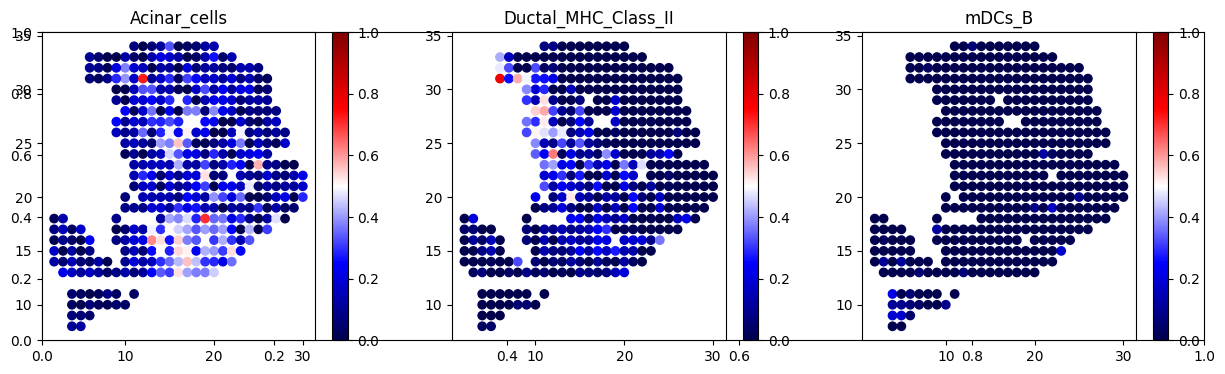

In [47]:
cell_idx = [0,4,9]
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 4))
for k in range(3):
    plt.subplot(1,3,k+1)

    plt.scatter(adata.obs['x'],adata.obs['y'],c=V[:,cell_idx[k]],cmap='seismic')
    plt.colorbar()
    plt.clim([0,1])
    plt.title(all_types[cell_idx[k]])
plt.show()

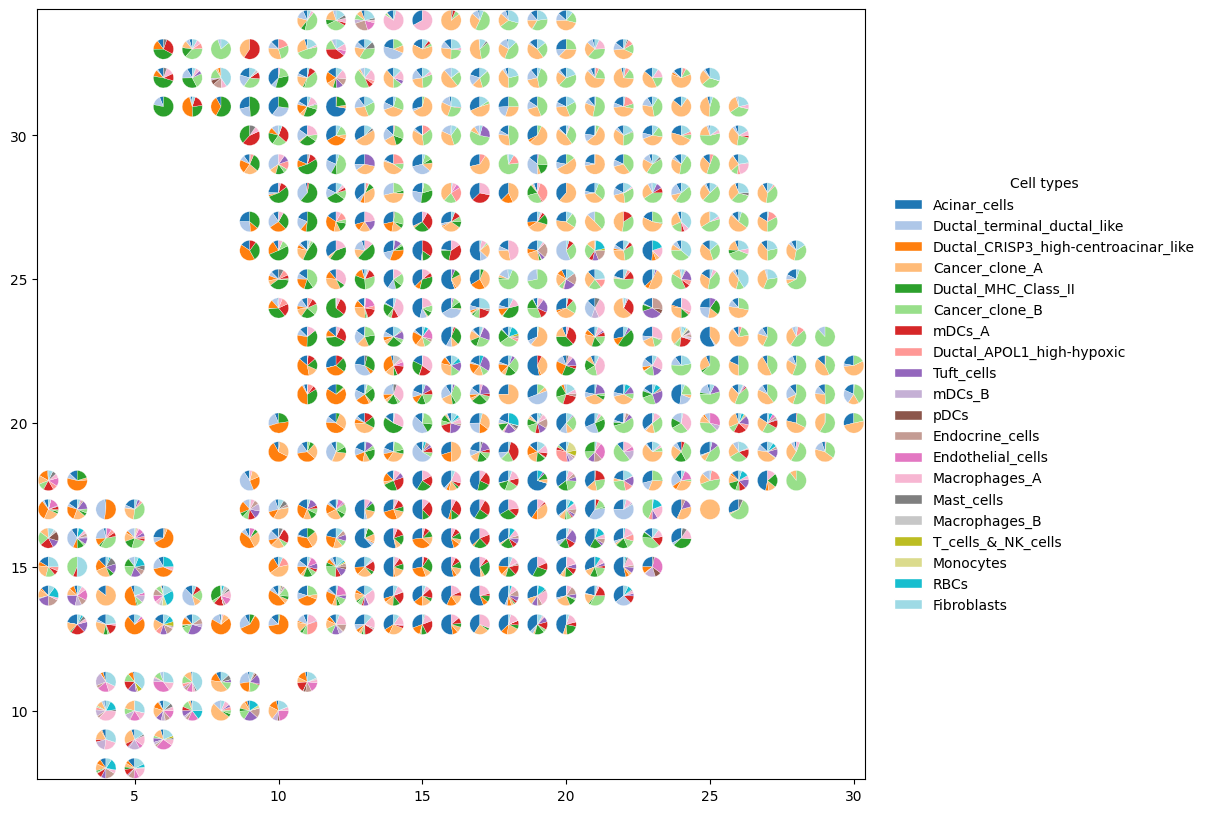

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

scatter_pies(ax, adata.obs['x'], adata.obs['y'], V, labels=pd_B.index.to_list(),top_n=None)

In [49]:
def perturb_and_subsample(
    adata, frac=0.5, noise_std=None, dropout_p=None, seed=None
):
    
    rng = np.random.default_rng(seed)

    # --- Subsample rows (cells) ---
    n_obs = adata.n_obs
    n_keep = int(np.ceil(frac * n_obs))
    keep_idx = rng.choice(n_obs, n_keep, replace=False)
    adata_sub = adata[keep_idx].copy()

    # --- Perturb X if requested ---
    X = adata_sub.X
    if hasattr(X, "toarray"):  # convert sparse if needed
        X = X.toarray()

    if noise_std is not None:
        X = X + rng.normal(0, noise_std, size=X.shape)

    if dropout_p is not None:
        mask = rng.random(X.shape) < dropout_p
        X = X.copy()
        X[mask] = 0

    adata_sub.X = X
    adata_sub.uns["perturbation"] = dict(
        noise_std=noise_std, dropout_p=dropout_p, frac=frac
    )
    return adata_sub

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/_utils/__init__.py:555: RuntimeWarning: overflow encountered in multiply
  return x * y
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: overflow encountered in square
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: invalid value encountered in subtract
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/l

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(214, 1533)
(1533, 20)
iter    0  f=6.009272e+06  rel_drop=4.423e-02  step=6.25e-05
iter   44  f=5.715003e+06  rel_drop=9.283e-06  step=1.56e-05
stopped after iteration # 44
stopped after iteration #44
(214, 1533)
(1533, 20)
iter    0  f=5.952136e+06  rel_drop=3.170e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:443: RuntimeWarning: divide by zero encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:443: RuntimeWarning: overflow encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:443: RuntimeWarning: invalid value encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V

iter   43  f=5.579426e+06  rel_drop=9.598e-06  step=1.56e-05
stopped after iteration # 43
stopped after iteration #43
(428, 1533)
(1533, 20)
iter    0  f=1.196194e+07  rel_drop=3.827e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:573: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:573: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:573: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:575: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:575: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:575: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-package

iter   44  f=1.129460e+07  rel_drop=9.272e-06  step=1.56e-05
stopped after iteration # 44
stopped after iteration #44
iter    0  f=1.129460e+07  rel_drop=6.596e-06
stopped after iteration # 0


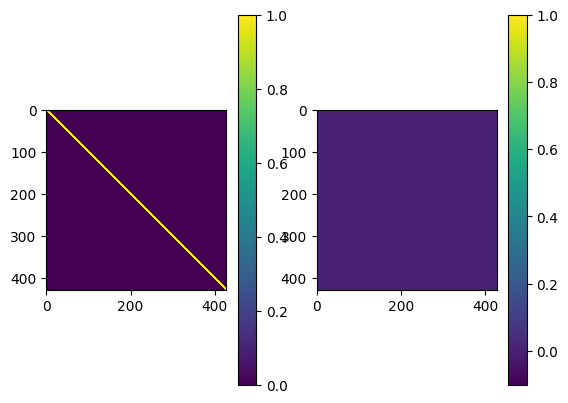

In [85]:

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]
# adata_group = [adata, adata]
V_all, pi, L = solve_V_all_slices(adata_group, pd_B, mu=.5, lam=50)

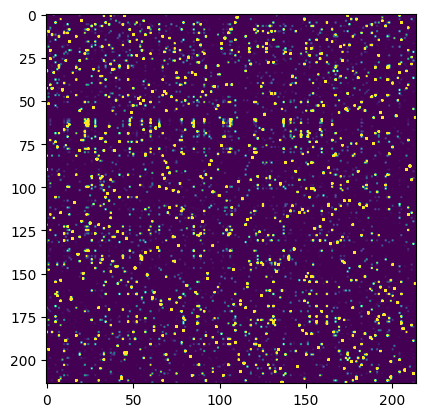

In [79]:
plt.imshow(pi[0])
plt.clim([0.,0.0001])

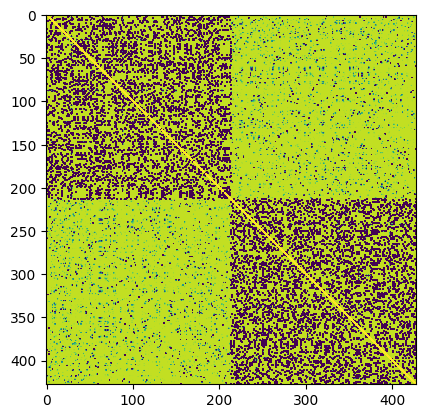

In [80]:
plt.imshow(L.todense())
plt.clim([-0.001,0.0001])

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(428, 1542)
(1542, 20)
iter    0  f=1.061253e+07  rel_drop=1.463e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=1.002541e+07  rel_drop=3.461e-05  step=1.56e-05
iter   65  f=1.002247e+07  rel_drop=9.919e-06  step=1.56e-05
stopped after iteration # 65
stopped after iteration #65
Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19736)
(428, 1542)
(1542, 20)
iter    0  f=1.061253e+07  rel_drop=1.463e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=1.002541e+07  rel_drop=3.461e-05  step=1.56e-05
iter   65  f=1.002247e+07  rel_drop=9.919e-06  step=1.56e-05
stopped after iteration # 65
stopped after iteration #65


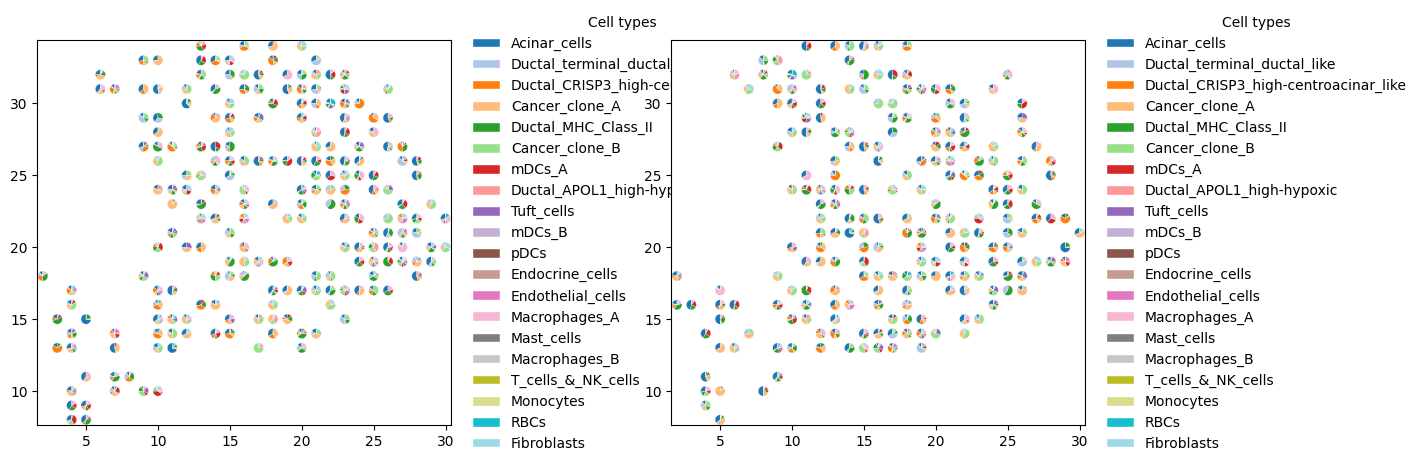

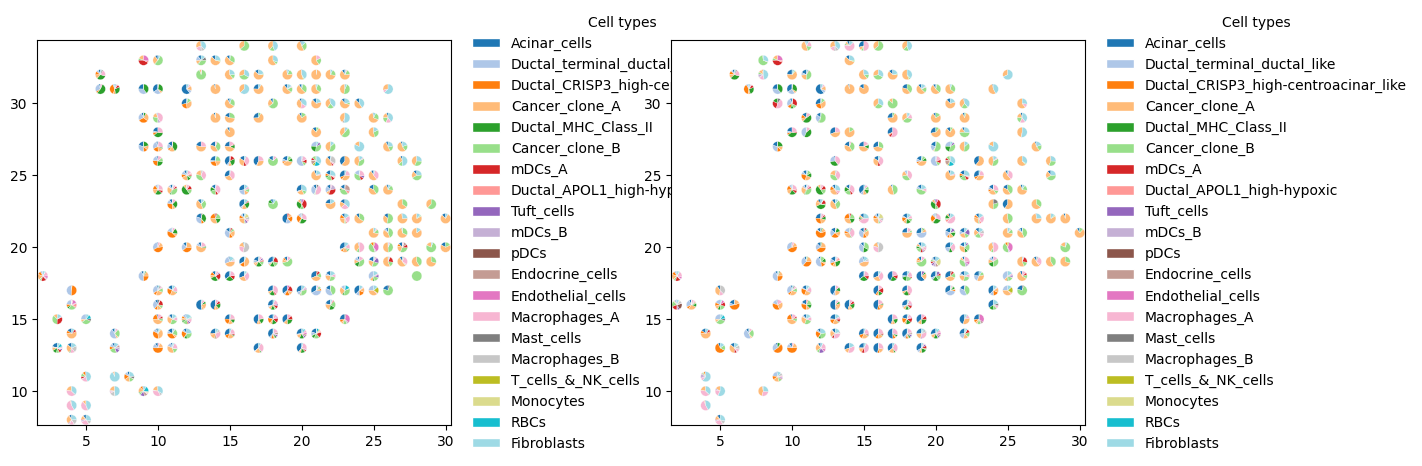

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

V = solve_V_per_slice(adata, pd_B, lam=1)
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
V = solve_V_per_slice(adata, pd_B, lam=1)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)

single slice each time


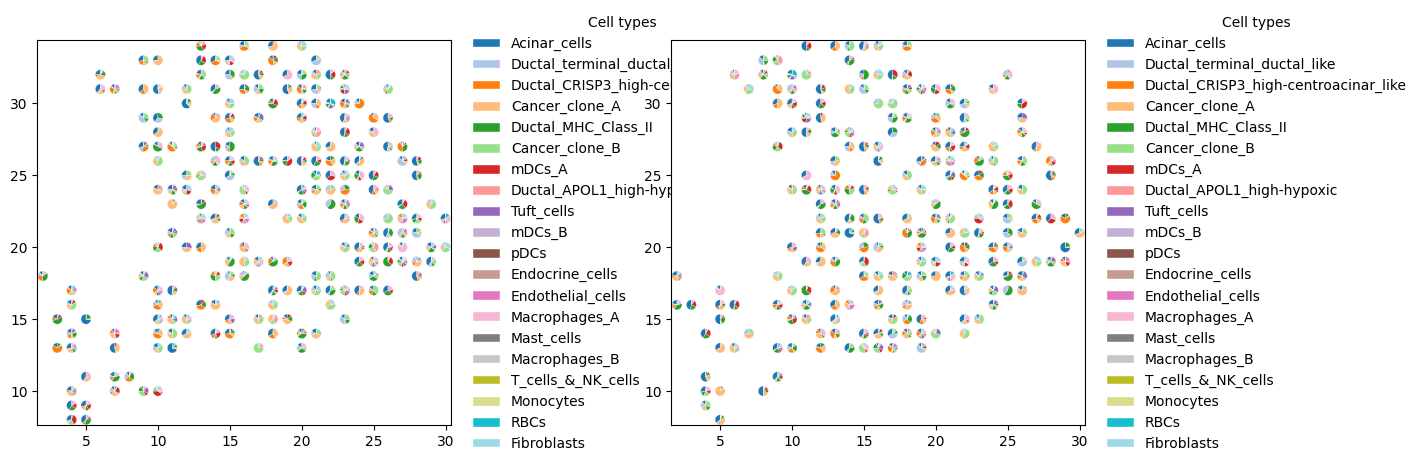

two slices jointly


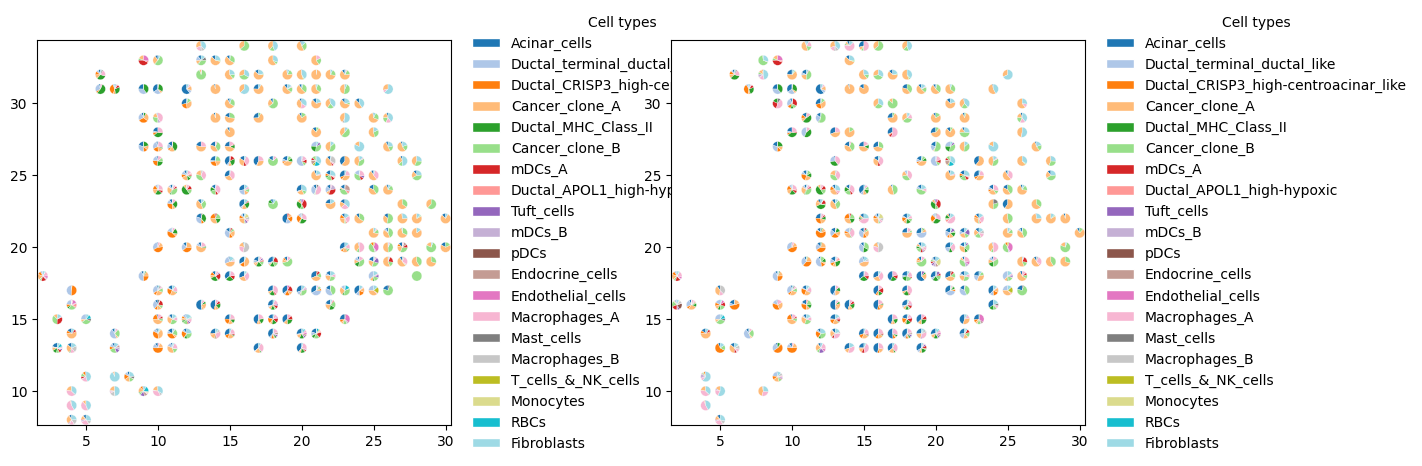

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

print('single slice each time')

# V = solve_V_per_slice(adata, pd_B, lam=0.1)
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
# V = solve_V_per_slice(adata, pd_B, lam=0.1)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
plt.show()

print('two slices jointly')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)
plt.show()